In [1]:
%reset -f
# import the necessary packages
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import seaborn as sns
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import argparse
import random
import cv2, glob
import os
import numpy as np
from insectrec.utils import get_dataset, train_generator, valid_generator, augment_trainset
# sns.set()
seed = 42
np.random.seed(seed)
batch_size = 32
nb_classes = 9

created_data_path = '/home/kalfasyan/data/images/sticky_plates/created_data'
path_impy_crops_export = f'{created_data_path}/impy_crops_export/'
path_images_augmented = f'{created_data_path}/images_augmented/'
img_dim = 150
modelname = 'model_platebased_DENSE121_dropout05_150.h5'

/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


nr of all plates: 267
nr of test plates: 24


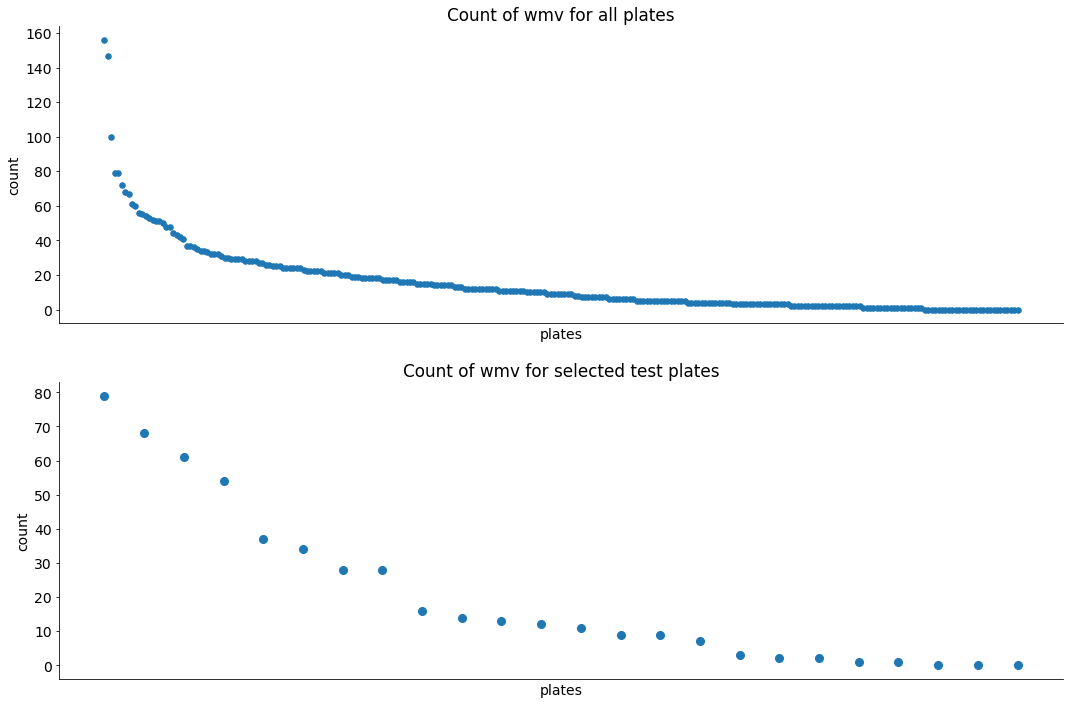

In [2]:
# Creating le for encoding labels
le = LabelEncoder()

# Creating dataframe with all the original data (x: filenames, textlabels, y: nummerical labels)
df_orig = pd.DataFrame()
df_orig['x'] = pd.Series(glob.glob(f"{path_impy_crops_export}/*/*.jpg"))
df_orig['pname'] = df_orig['x'].apply(lambda p: '_'.join(p.split('/')[-1][:-4].split('_')[:-3]))#df_orig['x'].apply(lambda p: '_'.join(p.split('/')[-1].split('.')[-2].split('_')[:-8]))
df_orig['y_text'] = df_orig['x'].apply(lambda x: x.split('/')[-2])
df_orig['y'] = le.fit_transform(df_orig.y_text)

target_insect_dict = {}
for i, sub in df_orig.groupby(['pname']):
    try:
        target_insect_dict[i] = sub['y_text'][sub['y_text']=='wmv'].value_counts()[0]
    except:
        target_insect_dict[i] = 0
ser = pd.Series(target_insect_dict, index=target_insect_dict.keys()).sort_values(ascending=False)

test_plates = [
    #'beauv_8719_C_84_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
              'kampen_w26_C_79_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
              'herent_09160819_10_F10_51 mm_ISO160_1-15 s',
              'kampen_w32_AA_17_F10_51 mm_ISO160_1-15 s_3daysold',
#               'kampen_w26_A_77_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
              'brainlal_w27_B_59_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
#               'beauv_8719_B_83_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
              'herent_09160819_13_F10_51 mm_ISO160_1-15 s',
              'beauv_w27_C_57_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
#               'brainlal_w27_A_58_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
              'her_2856719_03_03_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
              'herent_09160819_14_F10_51 mm_ISO160_1-15 s',
#               'brainelal_8719_C_82_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'beauvech_w37_B_F10_51 mm_ISO160_1-15 s',
#                'her_2128619_16_48_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'kampen_w27_AA_68_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'her_2128619_11_43_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'beauvech_w35_B_F10_51 mm_ISO160_1-15 s',
               'brainlal_15_7_B_62_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'brainelal_w35_A_F10_51 mm_ISO160_1-15 s',
               'beauv_w27_A_55_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'her_2856719_07_07_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'brainelal_w25_A_74_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'her_2128619_07_39_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'brainelal_w25_B_75_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'kampen_w28_A_64_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'beauv_w25_A_49_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'her_512719_14_30_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
               'kampen_w37_C_F10_51 mm_ISO160_1-15 s',
               'kampen_w39_B_F10_51 mm_ISO160_1-15 s'
              ]

X_test = df_orig.x[df_orig.pname.isin(test_plates)]
y_test = df_orig.y[df_orig.pname.isin(test_plates)]

X_test, y_test = shuffle(X_test, y_test, random_state=seed)
########  #############
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(18,12))

plt.subplot(211)
ax2 = ser.plot(style='.', markersize=11); 
plt.xlabel('plates'); plt.ylabel('count')
plt.title('Count of wmv for all plates')
print(f"nr of all plates: {ser.shape[0]}")
plt.xticks([], [])
plt.xticks(rotation=90)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.subplot(212)
ax1 = ser.loc[test_plates].plot(style='o', markersize=8); 
plt.xlabel('plates'); plt.ylabel('count')
plt.title('Count of wmv for selected test plates');
print(f"nr of test plates: {ser.loc[test_plates].shape[0]}")
plt.xticks([], [])
plt.xticks(rotation=90)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.savefig('test.png', bbox_inches = 'tight')


#########  #############

# X_test = df_orig.x[df_orig.pname.isin(test_plates)]
# y_test = df_orig.y[df_orig.pname.isin(test_plates)]

# X_test, y_test = shuffle(X_test, y_test, random_state=seed)

# print("Test set class balance")
# print(df_orig[df_orig.pname.isin(test_plates) ].y_text.value_counts())

# Splitting into train/val # plate based - new
# X_train = df_orig.x[~df_orig.pname.isin(test_plates)]
# y_train = df_orig.y[~df_orig.pname.isin(test_plates)]

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed, shuffle=True)

# Splitting into train/val # Randomly - old
# X_train, X_test, y_train, y_test = train_test_split(df_orig.x, df_orig.y, test_size=0.2, random_state=seed, shuffle=True)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed, shuffle=True)

X_test = X_test.tolist()
y_test = y_test.tolist()

## DenseNet121 trained from scratch

In [3]:
from tensorflow.keras.applications import NASNetLarge

base_model = DenseNet121(include_top=False, weights=None, 
                         input_shape=(img_dim,img_dim,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(nb_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
# model.summary()

In [4]:
import math
top_weights_path = f"{created_data_path}/weights/{modelname}"
model.load_weights(top_weights_path)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
pred = model.predict(valid_generator(X_test, y_test, batch_size=batch_size, nb_classes=nb_classes, img_dim=img_dim), 
                         steps= len(X_test) / batch_size, 
                         verbose=1)

In [6]:
y_pred = np.argmax(pred, axis=1)

In [7]:
def get_labelencoder_mapping(le):
    '''
    Return a dict mapping labels to their integer values
    from an SKlearn LabelEncoder
    le = a fitted SKlearn LabelEncoder
    '''
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

get_labelencoder_mapping(le)
name_map = dict(zip(le.transform(le.classes_), le.classes_))
print(name_map)

{0: 'bl', 1: 'bv', 2: 'c', 3: 'm', 4: 'sw', 5: 't', 6: 'v', 7: 'v(cy)', 8: 'wmv'}


## Confusion matrix

0.6874270774774094


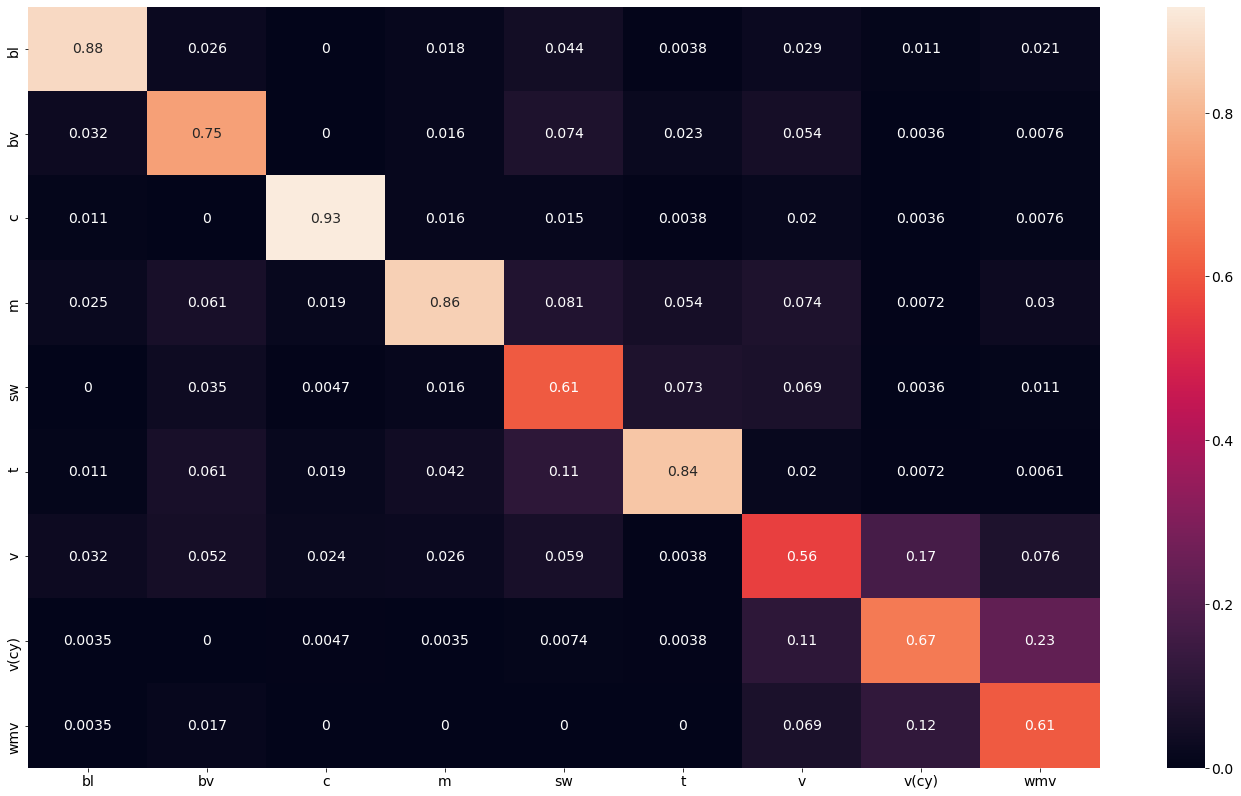

In [8]:
# from sklearn.metrics import accuracy_score
print(balanced_accuracy_score(y_test, y_pred))


plt.figure(figsize=(24,14))
cm = confusion_matrix(le.fit_transform(y_test), y_pred)
cm = cm / cm.astype(np.float).sum(axis=0)
sns.heatmap(cm, annot=True, xticklabels=list(name_map.values()), yticklabels=list(name_map.values()))
sns.set(font_scale=1.4)

<AxesSubplot:>

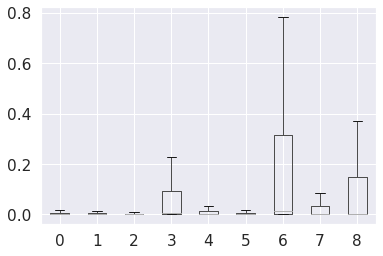

In [9]:
pd.DataFrame(pred).sort_values(by=8, ascending=False).boxplot(showfliers=False)

## Classification report

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85       311
           1       0.71      0.59      0.64       167
           2       0.90      0.85      0.88       233
           3       0.74      0.87      0.80       613
           4       0.57      0.51      0.54       175
           5       0.85      0.76      0.80       292
           6       0.51      0.72      0.60       563
           7       0.58      0.36      0.44       430
           8       0.69      0.59      0.64       489

    accuracy                           0.69      3273
   macro avg       0.71      0.68      0.69      3273
weighted avg       0.69      0.69      0.68      3273



## Actual number of flies vs Predicted by model

In [23]:
trgt = 5 # wmv code
acts, pred, pnames = [],[],[]
df_test['y_pred'] = y_pred
for i, sub in df_test.groupby('insect_plate_names'):
    acts.append(sub.actual_number.iloc[0])
    pred.append(sub[sub.y_pred == trgt].shape[0])
    pnames.append(sub.insect_plate_names.iloc[0])
#     print(f"\nplate: {sub.insect_plate_names.iloc[0]} \nactual: {sub.actual_number.iloc[0]}, predicted: {sub[sub.y_pred == trgt].shape[0]}")
#     break

covariance matrix: 
[[554.24456522  53.42934783]
 [ 53.42934783 223.65036232]]

Pearsons correlation: 0.152



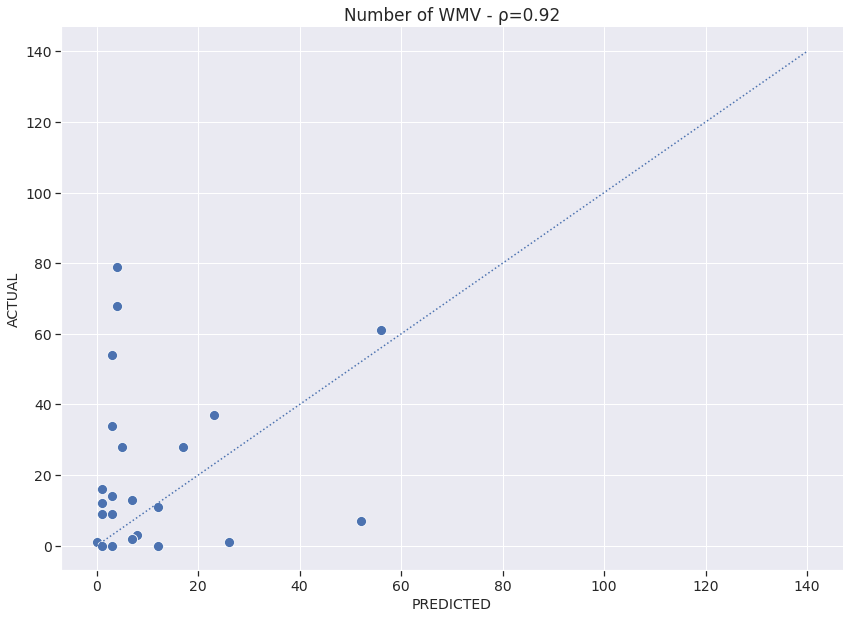

In [24]:
# sns.scatterplot(pred, acts)
df_plot = pd.DataFrame({"acts": acts, "pred": pred})

plt.figure(figsize=(14,10))
ax = sns.scatterplot(x="pred", y="acts", data=df_plot, ci=None, s=100);
ident = [0.0, 140.0]
plt.plot(ident,ident, ":")
plt.title("Number of WMV - ρ=0.92")
plt.xlabel("PREDICTED", fontsize=14)
plt.ylabel("ACTUAL", fontsize=14)
# plt.legend(['ρ=0.92'])

from scipy.stats import pearsonr
from numpy import cov

covariance = cov(df_plot.acts, df_plot.pred)
print(f"covariance matrix: \n{covariance}\n")

corr, _ = pearsonr(df_plot.acts, df_plot.pred)
print('Pearsons correlation: %.3f' % corr)
print()

ax.tick_params(axis='both', which='major', labelsize=14)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

In [25]:
df_plot['platenames'] = pnames
df_plot[['platenames','acts','pred']].set_index('platenames').sort_values(by='acts', ascending=False)

,acts,pred
platenames,,
kampen_w26_C_79_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160,79,4
herent_09160819_10_F10_51 mm_ISO160_1-15 s,68,4
kampen_w32_AA_17_F10_51 mm_ISO160_1-15 s_3daysold,61,56
brainlal_w27_B_59_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160,54,3
herent_09160819_13_F10_51 mm_ISO160_1-15 s,37,23
beauv_w27_C_57_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160,34,3
her_2856719_03_03_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160,28,17
herent_09160819_14_F10_51 mm_ISO160_1-15 s,28,5
beauvech_w37_B_F10_51 mm_ISO160_1-15 s,16,1


In [26]:
data1

NameError: name 'data1' is not defined